In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,8)

In [3]:
!gdown 16TAoRZ3S8ebgIq3dPQmWIXPw_1dZy3ta


Downloading...
From: https://drive.google.com/uc?id=16TAoRZ3S8ebgIq3dPQmWIXPw_1dZy3ta
To: /content/rest_vis.csv
100% 13.1k/13.1k [00:00<00:00, 28.2MB/s]


In [4]:
df = pd.read_csv('/content/rest_vis.csv')
df.head()

,date,weekday,holiday,total
0,1/1/2016,Friday,1,296.0
1,1/2/2016,Saturday,0,191.0
2,1/3/2016,Sunday,0,202.0
3,1/4/2016,Monday,0,105.0
4,1/5/2016,Tuesday,0,98.0


In [5]:
df.shape

(517, 4)

In [6]:
df.isna().sum()

,0
date,0
weekday,0
holiday,0
total,39


In [7]:
df1 = df.copy()

In [8]:
df.dropna(inplace=True)

In [10]:
df.shape

(478, 4)

In [11]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)
df.head(5)

,weekday,holiday,total
date,,,
2016-01-01,Friday,1,296.0
2016-01-02,Saturday,0,191.0
2016-01-03,Sunday,0,202.0
2016-01-04,Monday,0,105.0
2016-01-05,Tuesday,0,98.0


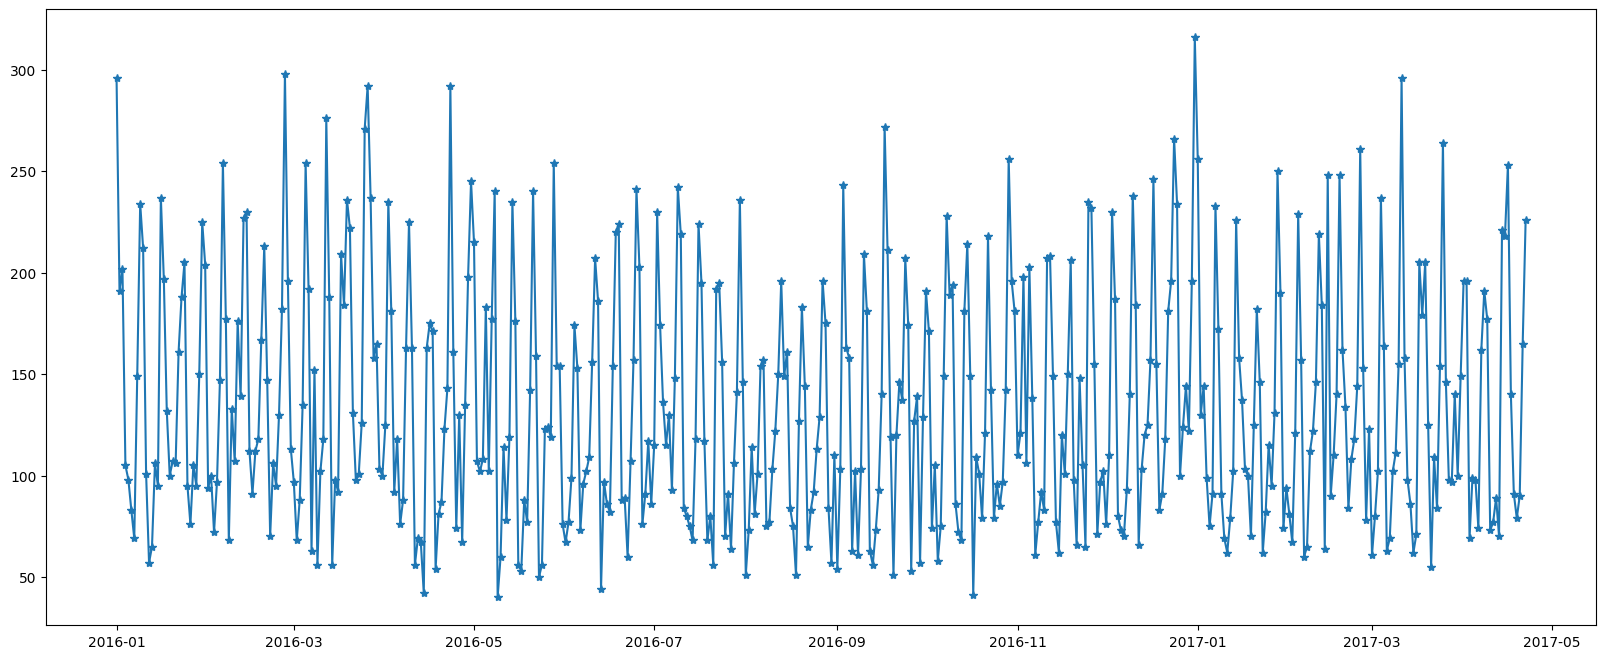

In [12]:
# Lets take a look at our time series plot
plt.plot(df.index, df['total'], '-*')
plt.show()

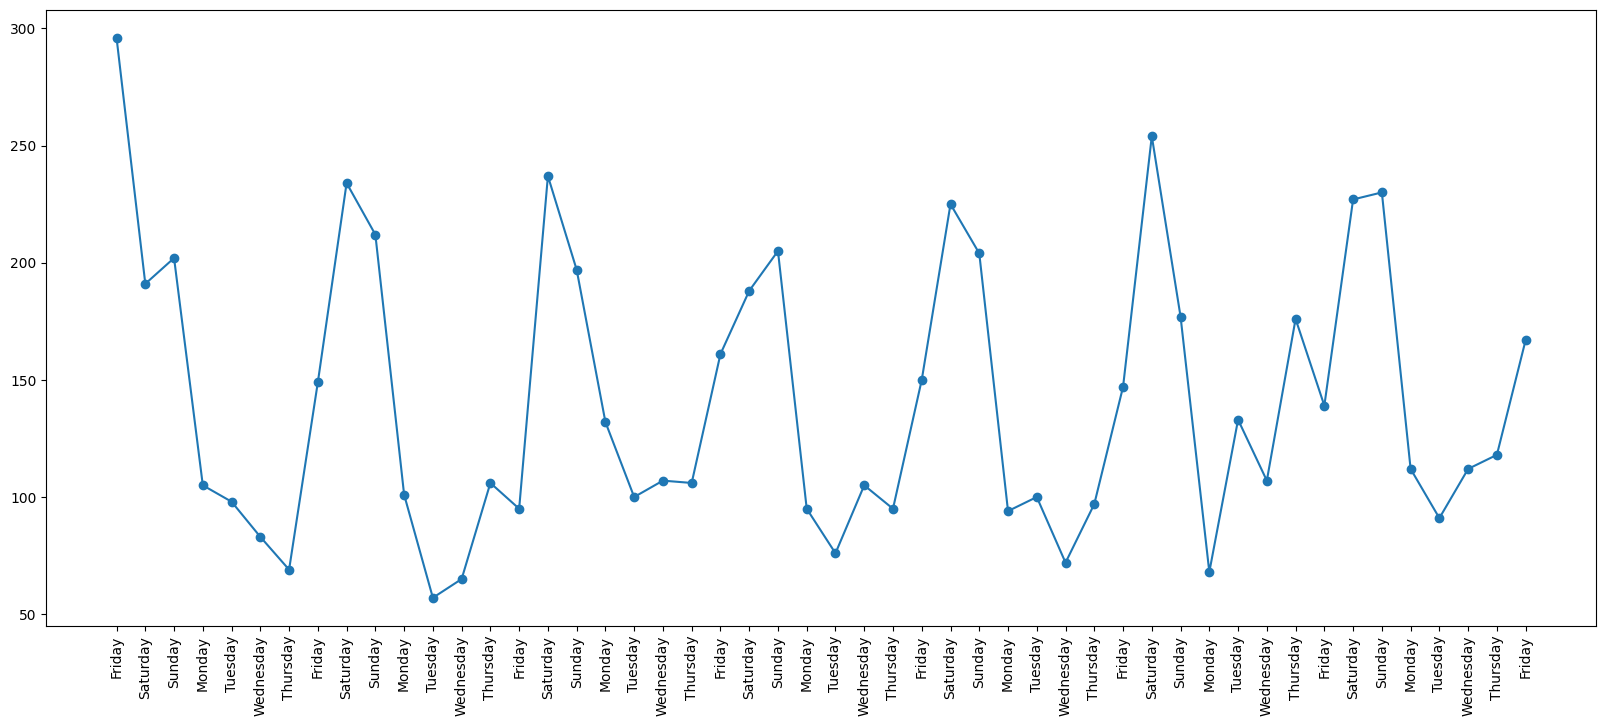

In [13]:
plt.plot(range(50),df['total'][:50], '-o')
plt.xticks(range(0,50), df['weekday'][:50],rotation = 90)
plt.show()

In [14]:
df.head()

,weekday,holiday,total
date,,,
2016-01-01,Friday,1,296.0
2016-01-02,Saturday,0,191.0
2016-01-03,Sunday,0,202.0
2016-01-04,Monday,0,105.0
2016-01-05,Tuesday,0,98.0


In [16]:
df["holiday"].value_counts()

,count
holiday,
0,446
1,32


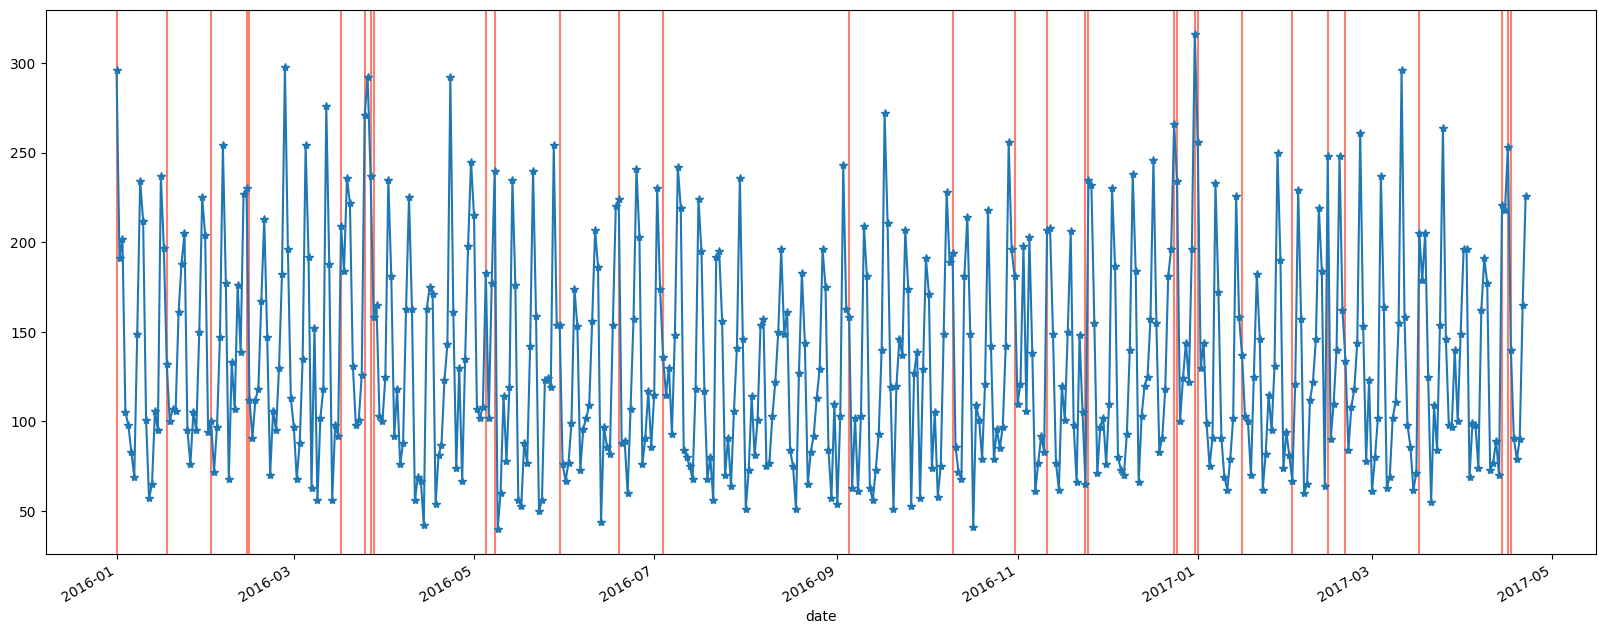

In [17]:
holidays = df.loc[df.holiday==1].index
for hday in holidays:
    plt.axvline(x=hday, color='#FA8072')
df.total.plot(style='-*')
plt.show()

<Figure size 2000x800 with 0 Axes>

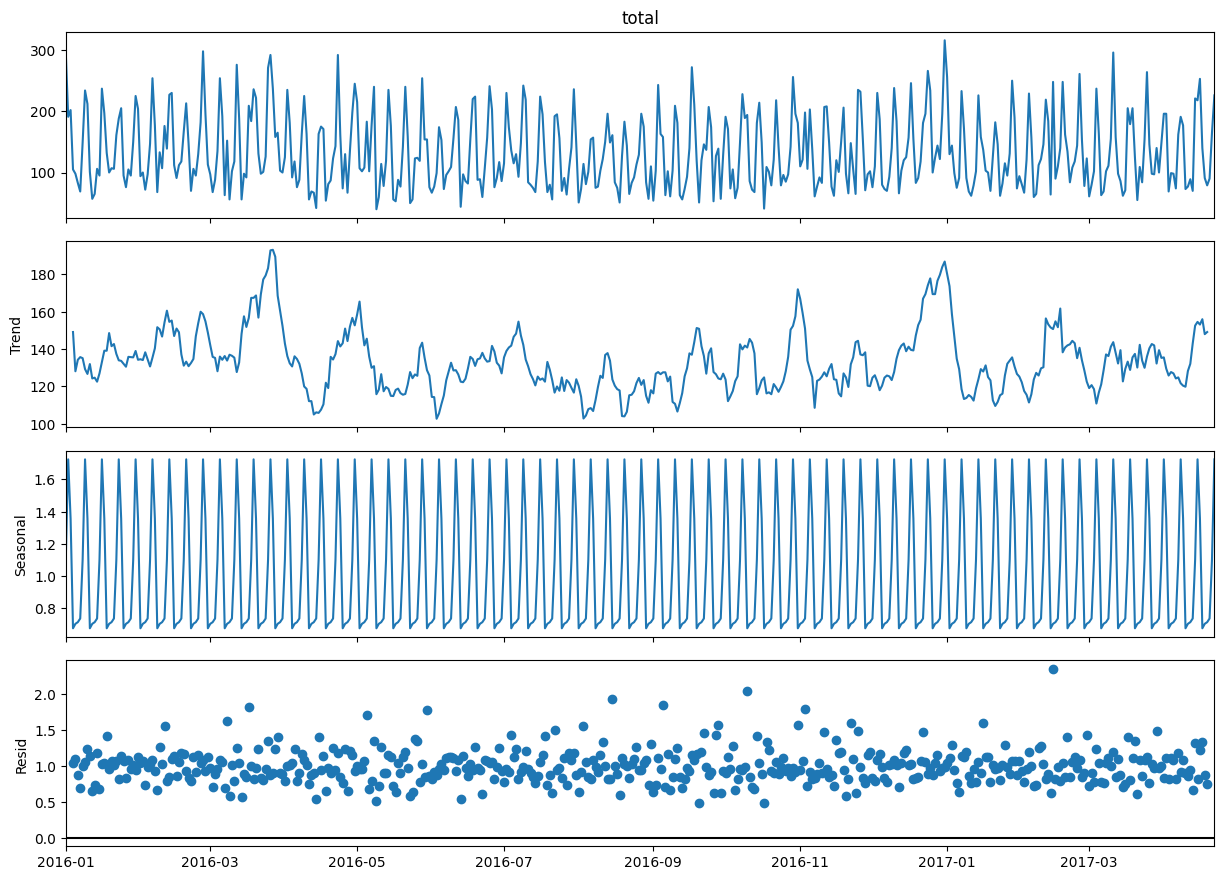

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['total'], model='multiplicative')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12, 9)
fig.show()

In [19]:
train = df.iloc[:436]
test = df.iloc[436:]

In [20]:
test.tail()

,weekday,holiday,total
date,,,
2017-04-18,Tuesday,0,91.0
2017-04-19,Wednesday,0,79.0
2017-04-20,Thursday,0,90.0
2017-04-21,Friday,0,165.0
2017-04-22,Saturday,0,226.0


In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [22]:
model = SARIMAX(train['total'],seasonal_order=(1,0,1,7))
results = model.fit()
fc = results.forecast(42)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


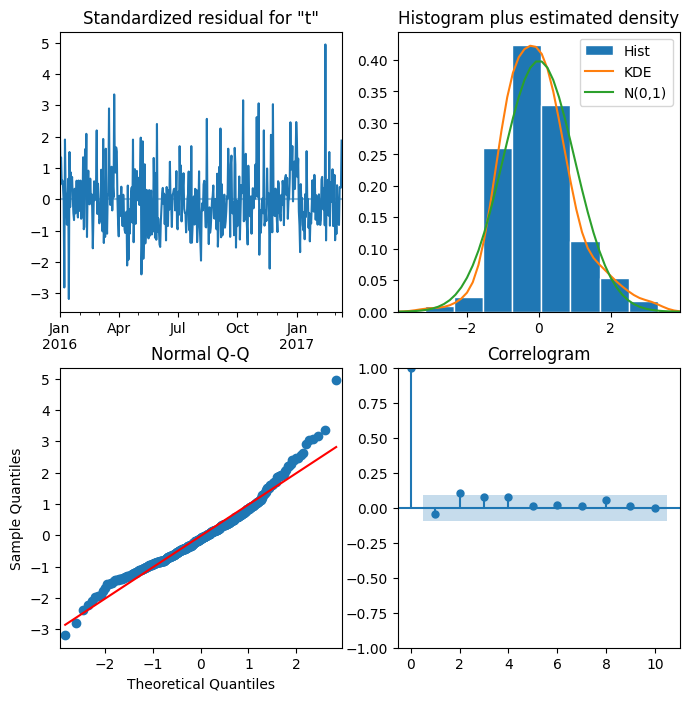

In [23]:
results.plot_diagnostics(figsize=(8,8));

In [24]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end)


In [25]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape

)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

MAE : 25.159
RMSE : 31.97
MAPE: 0.202


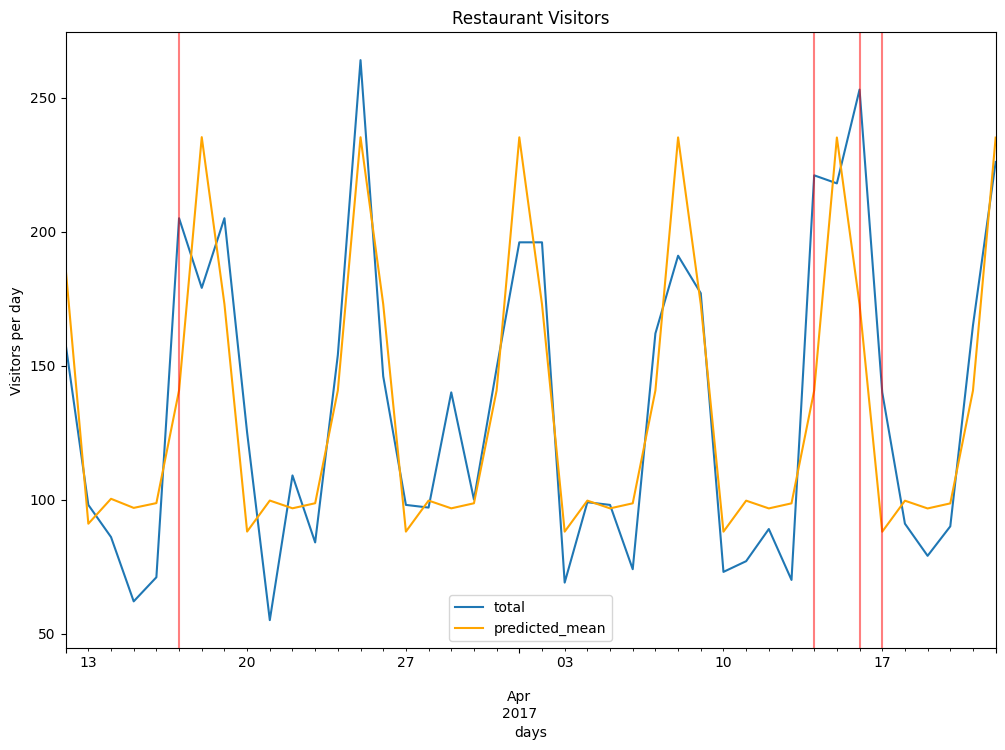

In [26]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='days'
ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha = 0.5)

In [27]:
model = SARIMAX(train['total'],exog = train["holiday"], seasonal_order=(1,0,1,7))
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [28]:
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

MAE : 18.903
RMSE : 23.263
MAPE: 0.163


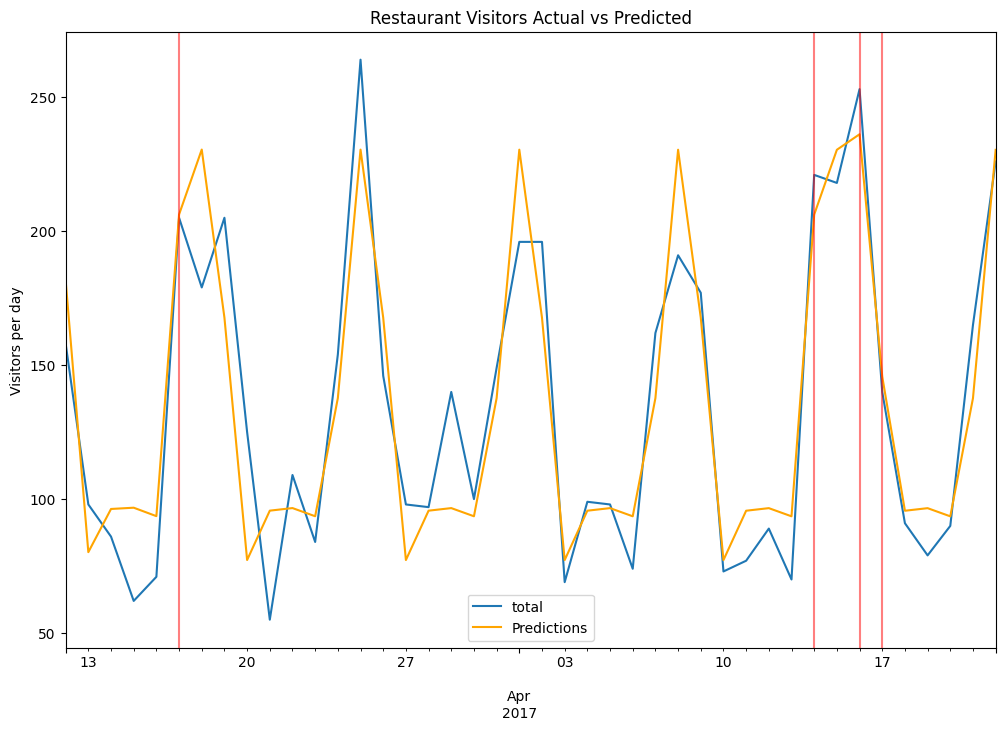

In [29]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha = 0.5);


In [46]:
model = SARIMAX(train['total'],exog = train["holiday"], order = (1,0,1), seasonal_order=(1,0,1,7))
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [47]:
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

MAE : 18.483
RMSE : 22.986
MAPE: 0.159


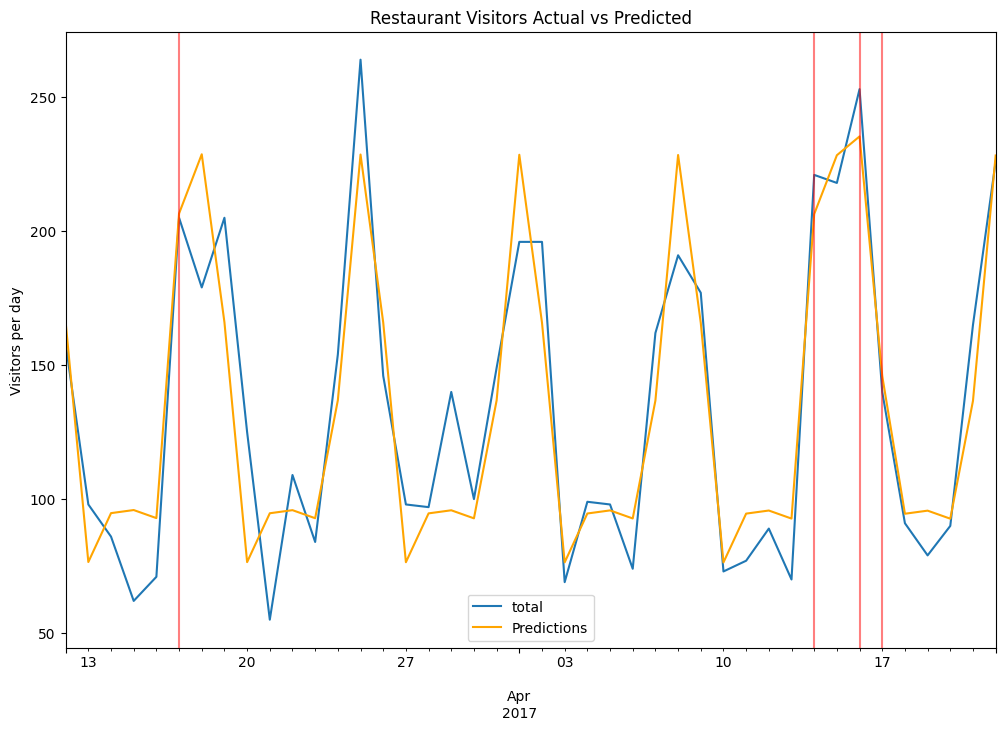

In [48]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha = 0.5);


In [49]:
# Linear Regression

In [50]:
df = df1.copy()
df['date'] = pd.to_datetime(df['date'])

In [51]:
df.head()

,date,weekday,holiday,total
0,2016-01-01,Friday,1,296.0
1,2016-01-02,Saturday,0,191.0
2,2016-01-03,Sunday,0,202.0
3,2016-01-04,Monday,0,105.0
4,2016-01-05,Tuesday,0,98.0


In [52]:
df["weekday"] = np.where(((df["weekday"] == "Friday") | (df["weekday"] == "Thursday") | (df["weekday"] == "Wednesday") | (df["weekday"] == "Tuesday") | (df["weekday"] == "Monday")), "working_day", "weekend")
intmdt = pd.get_dummies(df['weekday'])
df = pd.concat([df, intmdt],axis =1 )
df.head()

,date,weekday,holiday,total,weekend,working_day
0,2016-01-01,working_day,1,296.0,False,True
1,2016-01-02,weekend,0,191.0,True,False
2,2016-01-03,weekend,0,202.0,True,False
3,2016-01-04,working_day,0,105.0,False,True
4,2016-01-05,working_day,0,98.0,False,True


In [53]:
for i in range(1,32):
  df["Lag_{}".format(i)] = df['total'].shift(i)

In [54]:
lis = ['Lag_{}'.format(i) for i in range(1,32)]
df.dropna(inplace = True)    # Drop because some Lags will be NaN.
df['last_month_avg_level'] = df.loc[:,lis].sum(axis=1)/31
df.head()

,date,weekday,holiday,total,weekend,working_day,Lag_1,Lag_2,Lag_3,Lag_4,...,Lag_23,Lag_24,Lag_25,Lag_26,Lag_27,Lag_28,Lag_29,Lag_30,Lag_31,last_month_avg_level
31,2016-02-01,working_day,0,94.0,False,True,204.0,225.0,150.0,95.0,...,234.0,149.0,69.0,83.0,98.0,105.0,202.0,191.0,296.0,143.419355
32,2016-02-02,working_day,1,100.0,False,True,94.0,204.0,225.0,150.0,...,212.0,234.0,149.0,69.0,83.0,98.0,105.0,202.0,191.0,136.903226
33,2016-02-03,working_day,0,72.0,False,True,100.0,94.0,204.0,225.0,...,101.0,212.0,234.0,149.0,69.0,83.0,98.0,105.0,202.0,133.967742
34,2016-02-04,working_day,0,97.0,False,True,72.0,100.0,94.0,204.0,...,57.0,101.0,212.0,234.0,149.0,69.0,83.0,98.0,105.0,129.774194
35,2016-02-05,working_day,0,147.0,False,True,97.0,72.0,100.0,94.0,...,65.0,57.0,101.0,212.0,234.0,149.0,69.0,83.0,98.0,129.516129


In [55]:
lis = ['Lag_{}'.format(i) for i in range(1,8)]
df['last_week_avg_level'] = df.loc[:,lis].sum(axis=1)/7
df.head(3)

,date,weekday,holiday,total,weekend,working_day,Lag_1,Lag_2,Lag_3,Lag_4,...,Lag_24,Lag_25,Lag_26,Lag_27,Lag_28,Lag_29,Lag_30,Lag_31,last_month_avg_level,last_week_avg_level
31,2016-02-01,working_day,0,94.0,False,True,204.0,225.0,150.0,95.0,...,149.0,69.0,83.0,98.0,105.0,202.0,191.0,296.0,143.419355,135.714286
32,2016-02-02,working_day,1,100.0,False,True,94.0,204.0,225.0,150.0,...,234.0,149.0,69.0,83.0,98.0,105.0,202.0,191.0,136.903226,135.571429
33,2016-02-03,working_day,0,72.0,False,True,100.0,94.0,204.0,225.0,...,212.0,234.0,149.0,69.0,83.0,98.0,105.0,202.0,133.967742,139.000000


In [56]:
lis = ["Lag_{}".format(i) for i in range(1,15)]
df['last_2week_avg_level'] = df.loc[:,lis].sum(axis = 1)/14
df.head(3)

,date,weekday,holiday,total,weekend,working_day,Lag_1,Lag_2,Lag_3,Lag_4,...,Lag_25,Lag_26,Lag_27,Lag_28,Lag_29,Lag_30,Lag_31,last_month_avg_level,last_week_avg_level,last_2week_avg_level
31,2016-02-01,working_day,0,94.0,False,True,204.0,225.0,150.0,95.0,...,69.0,83.0,98.0,105.0,202.0,191.0,296.0,143.419355,135.714286,139.214286
32,2016-02-02,working_day,1,100.0,False,True,94.0,204.0,225.0,150.0,...,149.0,69.0,83.0,98.0,105.0,202.0,191.0,136.903226,135.571429,136.500000
33,2016-02-03,working_day,0,72.0,False,True,100.0,94.0,204.0,225.0,...,234.0,149.0,69.0,83.0,98.0,105.0,202.0,133.967742,139.000000,136.500000


In [57]:
df['dayofweek'] = df['date'].dt.dayofweek
df['sale_wrt_dow'] = df.groupby('dayofweek')['total'].transform('mean')
df[['sale_wrt_dow', 'dayofweek']].drop_duplicates()

,sale_wrt_dow,dayofweek
31,89.593750,0
32,94.531250,1
33,94.687500,2
34,99.015625,3
35,147.171875,4
36,229.125000,5
37,178.460317,6


In [58]:
df.shape

(447, 42)

In [59]:
df.columns

Index(['date', 'weekday', 'holiday', 'total', 'weekend', 'working_day',
       'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8',
       'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15',
       'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19', 'Lag_20', 'Lag_21', 'Lag_22',
       'Lag_23', 'Lag_24', 'Lag_25', 'Lag_26', 'Lag_27', 'Lag_28', 'Lag_29',
       'Lag_30', 'Lag_31', 'last_month_avg_level', 'last_week_avg_level',
       'last_2week_avg_level', 'dayofweek', 'sale_wrt_dow'],
      dtype='object')

In [60]:
import copy             #dfo has the data with all the columns
dfo = df.copy()

In [61]:
df = dfo.copy()
df = df[['total', 'Lag_1', 'last_month_avg_level', 'last_week_avg_level',
          'last_2week_avg_level', 'sale_wrt_dow', 'holiday']]
df.head()

,total,Lag_1,last_month_avg_level,last_week_avg_level,last_2week_avg_level,sale_wrt_dow,holiday
31,94.0,204.0,143.419355,135.714286,139.214286,89.593750,0
32,100.0,94.0,136.903226,135.571429,136.500000,94.531250,1
33,72.0,100.0,133.967742,139.000000,136.500000,94.687500,0
34,97.0,72.0,129.774194,134.285714,134.000000,99.015625,0
35,147.0,97.0,129.516129,134.571429,133.357143,147.171875,0


In [63]:
train = df.iloc[:df.shape[0]-42].dropna()
test = df.iloc[df.shape[0]-42:]


train_X = train.drop(["total"],axis =1)
train_y = train['total']
test_X = test.drop(["total"],axis =1)
test_y = test['total']

In [64]:
train_X

,Lag_1,last_month_avg_level,last_week_avg_level,last_2week_avg_level,sale_wrt_dow,holiday
31,204.0,143.419355,135.714286,139.214286,89.593750,0
32,94.0,136.903226,135.571429,136.500000,94.531250,1
33,100.0,133.967742,139.000000,136.500000,94.687500,0
34,72.0,129.774194,134.285714,134.000000,99.015625,0
35,97.0,129.516129,134.571429,133.357143,147.171875,0
...,...,...,...,...,...,...
431,63.0,137.612903,118.571429,126.857143,94.531250,0
432,69.0,132.451613,110.857143,125.785714,94.687500,0
433,102.0,130.677419,116.714286,125.357143,99.015625,0
434,111.0,132.322581,121.142857,124.857143,147.171875,0


In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape

# Train and pred
model = LinearRegression()
model.fit(train_X, train_y)
y_pred = pd.Series(model.predict(test_X), index=test.index)
mape(test['total'],y_pred)

0.1550950649148067

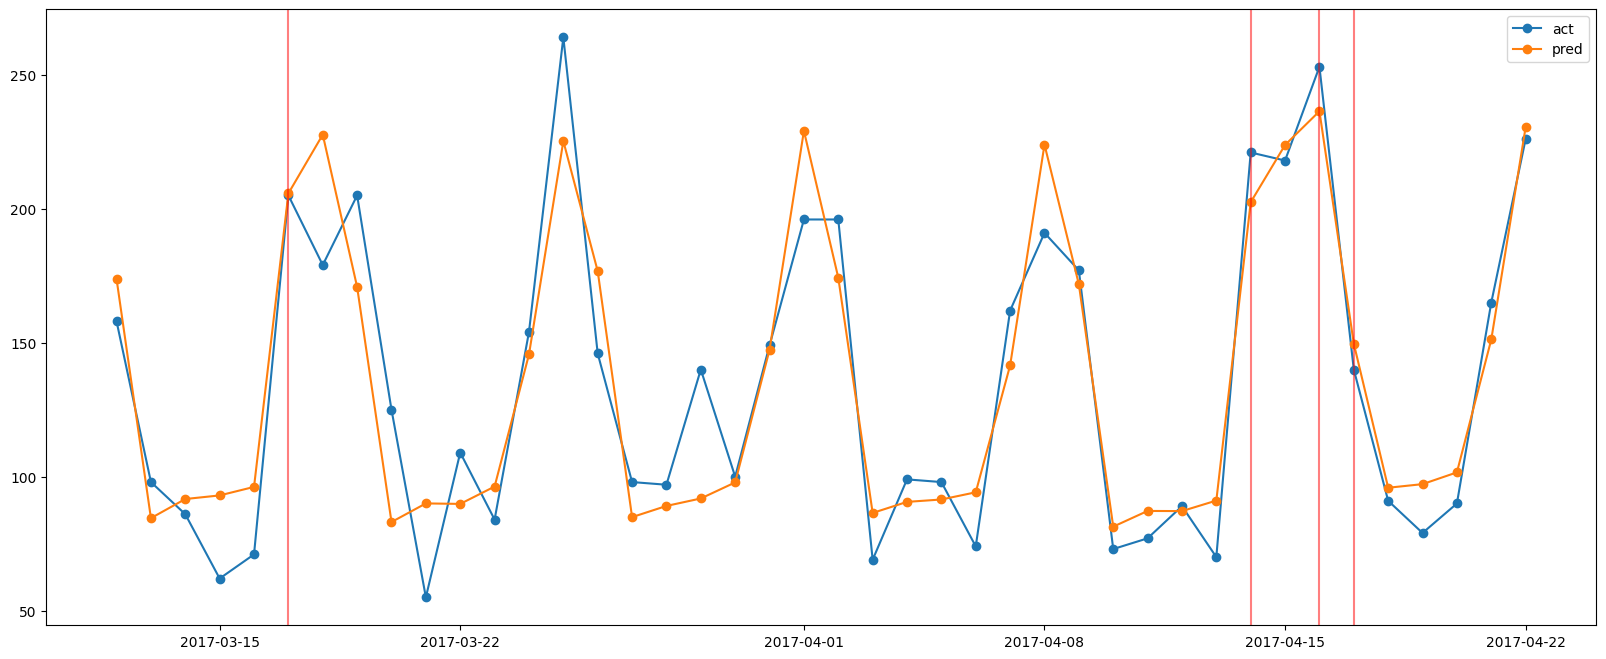

In [66]:
plt.plot(dfo.tail(42)['date'], test_y, '-o', label='act')
plt.plot(dfo.tail(42)['date'], y_pred, '-o', label='pred')
for x in dfo[-42:].query('holiday==1')['date']:
    plt.axvline(x=x, color='red', alpha = 0.5)
plt.legend()


In [67]:
# Prophet

In [68]:
df = df1.copy()

In [69]:
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['total']
df = df[['ds', 'y', 'holiday']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       517 non-null    datetime64[ns]
 1   y        478 non-null    float64       
 2   holiday  517 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 12.2 KB


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lj5n7h8/mvh6wqtn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lj5n7h8/k5ov1ip9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17018', 'data', 'file=/tmp/tmp0lj5n7h8/mvh6wqtn.json', 'init=/tmp/tmp0lj5n7h8/k5ov1ip9.json', 'output', 'file=/tmp/tmp0lj5n7h8/prophet_modelfi5tg73o/prophet_model-20240802172438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:24:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


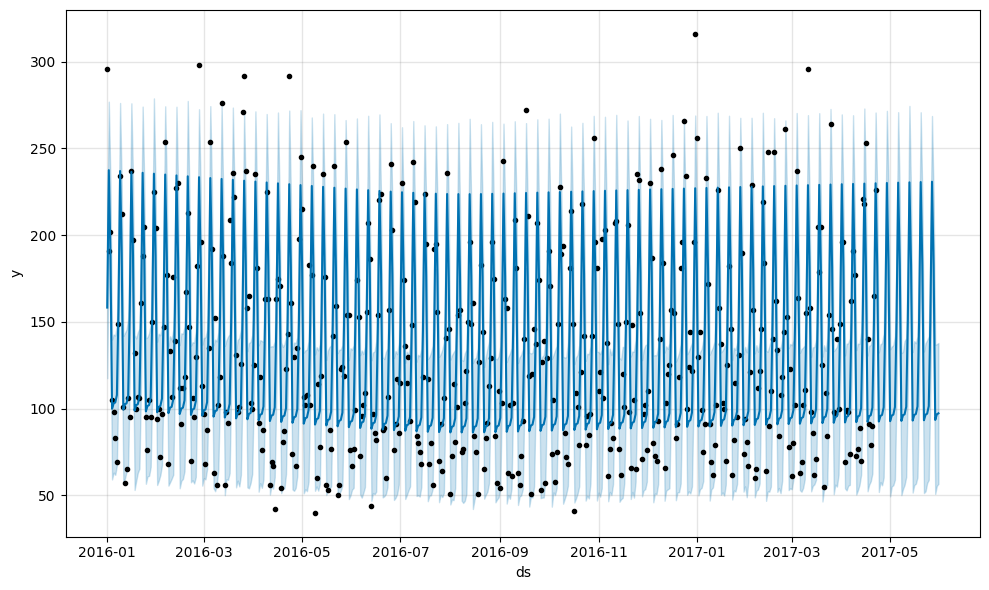

In [70]:
from prophet import Prophet
m = Prophet()
m.fit(df[['ds', 'y']][:-39]) #here we are leaving last 39 observations because we will predict it in 'future'
future = m.make_future_dataframe(periods=39,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

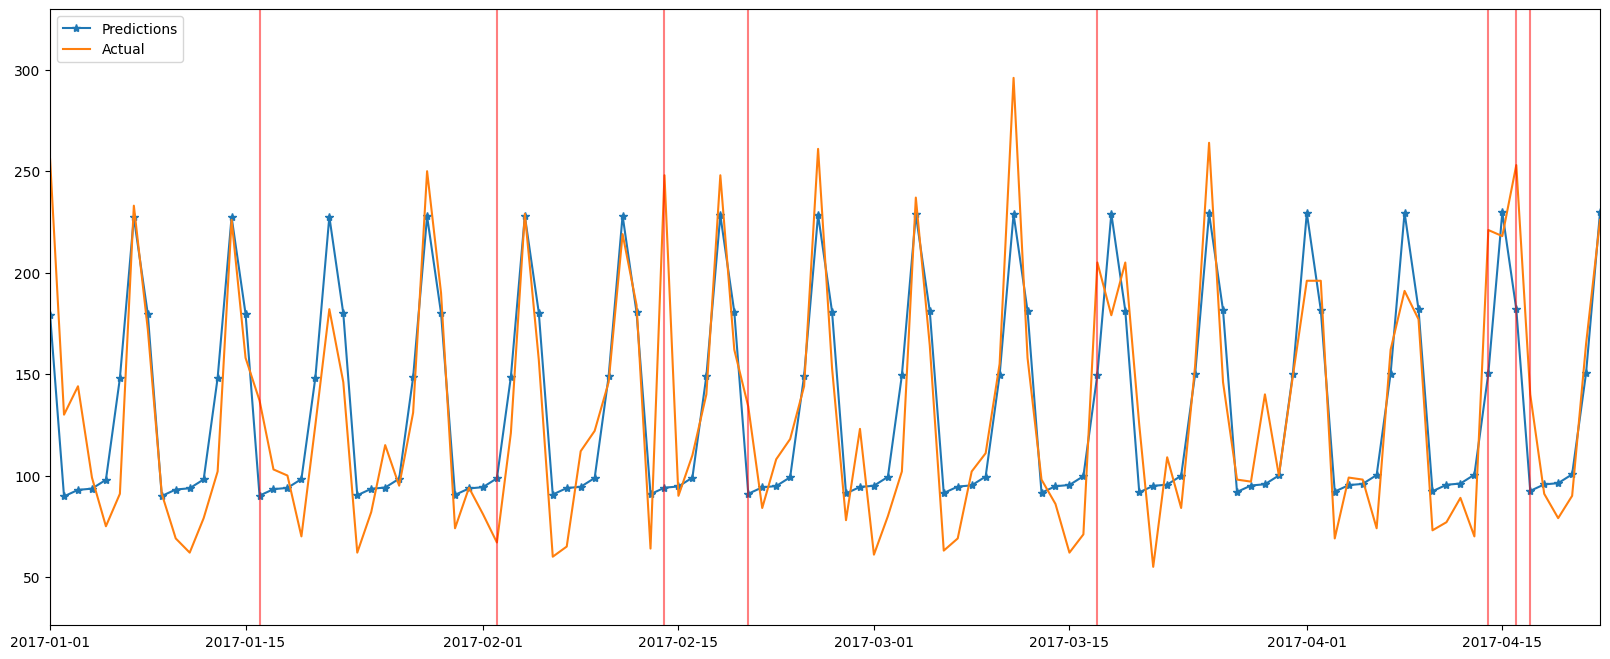

In [71]:
plt.plot(forecast['ds'], forecast['yhat'],'-*', label = 'Predictions')
plt.plot(df['ds'], df['y'], label = 'Actual')
for x in df.query('holiday==1')['ds']:
    plt.axvline(x=x, color='red', alpha = 0.5);
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2017-04-22'))
plt.legend()

In [72]:
performance(df['y'][:-39],forecast['yhat'][:-39])


MAE : 24.057
RMSE : 31.984
MAPE: 0.213


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lj5n7h8/_4gu6p8m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lj5n7h8/xs0vb5mo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13809', 'data', 'file=/tmp/tmp0lj5n7h8/_4gu6p8m.json', 'init=/tmp/tmp0lj5n7h8/xs0vb5mo.json', 'output', 'file=/tmp/tmp0lj5n7h8/prophet_modelix93aqrm/prophet_model-20240802172725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


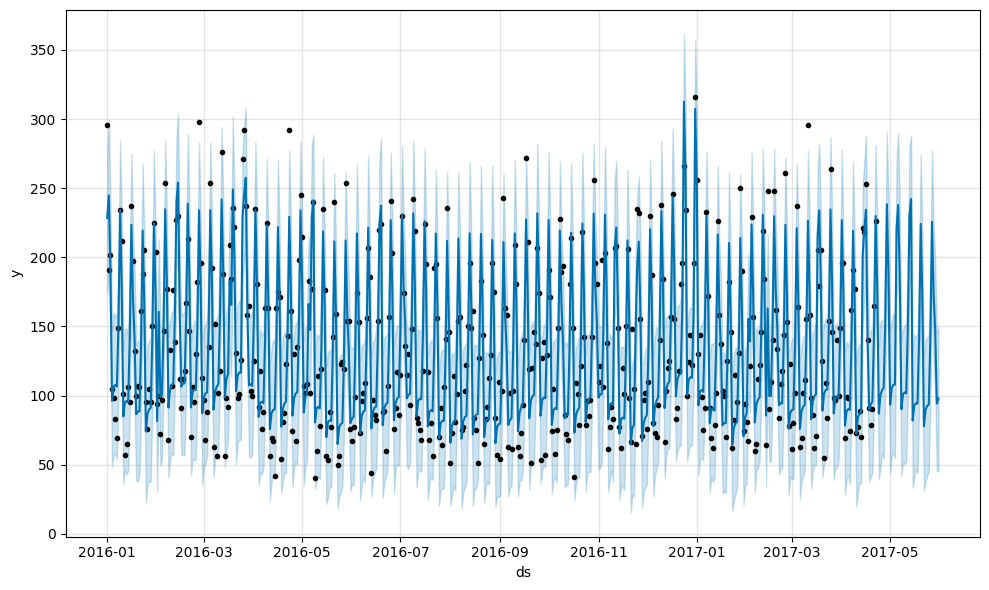

In [73]:
model2=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True,
               changepoint_prior_scale=4)
model2.add_regressor('holiday') #adding holidays data in the model3
model2.fit(df[:-39])
forecast2 = model2.predict(df)
fig = model2.plot(forecast2)

In [75]:
performance(df['y'][:-39],forecast2['yhat'][:-39])


MAE : 19.923
RMSE : 25.671
MAPE: 0.18


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lj5n7h8/ihj_63hy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0lj5n7h8/ltjt8k_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80283', 'data', 'file=/tmp/tmp0lj5n7h8/ihj_63hy.json', 'init=/tmp/tmp0lj5n7h8/ltjt8k_h.json', 'output', 'file=/tmp/tmp0lj5n7h8/prophet_modeld1hq71uo/prophet_model-20240802172934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:29:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


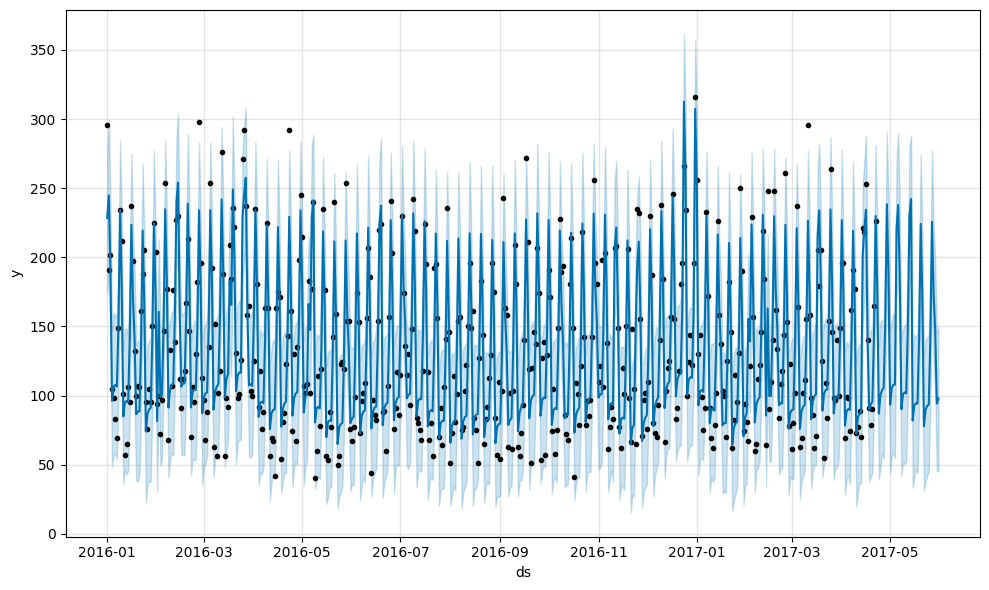

In [76]:
model3=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True,
               changepoint_prior_scale=4)
model3.add_country_holidays(country_name='US') #adding holidays data in the model2
model3.fit(df[:-39])
future = m.make_future_dataframe(periods=39,freq="D")
forecast3 = model3.predict(df)
fig = model3.plot(forecast2)

In [77]:
performance(df['y'][:-39],forecast3['yhat'][:-39])


MAE : 20.942
RMSE : 27.732
MAPE: 0.184


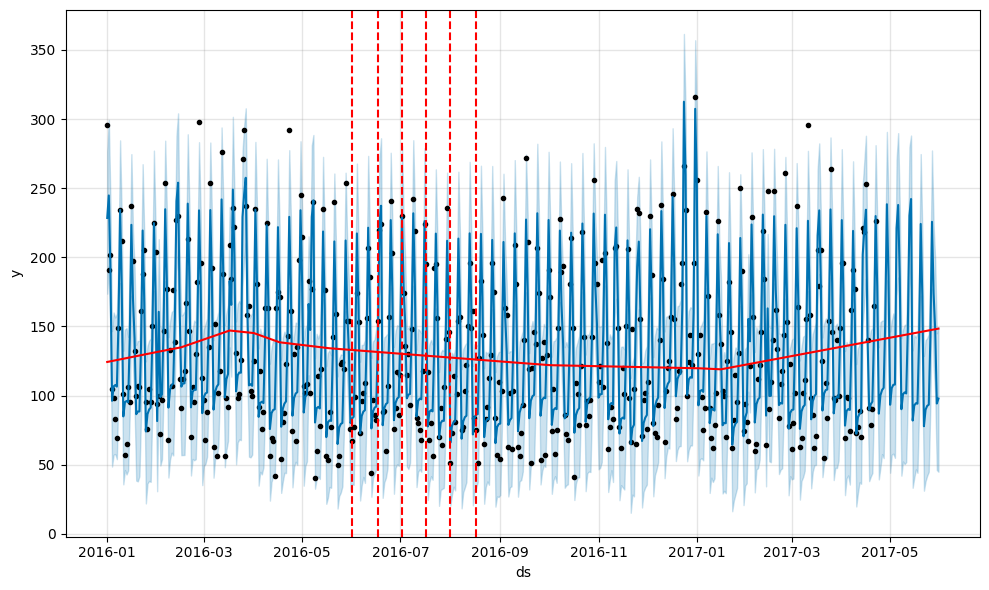

In [78]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m, forecast2)